In [1]:
# TODO: 
# - Reimplement using the same method of our pecnet (Add sequences to adding 0 to the error input data)
# - In our pecnet use mean5 to normalize the label. (Or use mean7 here)
# - use highest frequence for window sliding for all networks
#################  PECNET    #################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import yfinance as yf
#from keras.models import load_model
# import plotly.graph_objects as go
# from datetime import datetime
# import pandas_ta as ta
# import streamlit as st

import pandas as pd
from datetime import timedelta
import csv
from yahoofinancials import YahooFinancials
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from tqdm import tqdm
from keras import Sequential
from tensorflow.keras.optimizers.legacy import SGD
# from tensorflow.keras.utils import plot_model 
from keras.layers import Dense, Dropout
# from tensorflow.keras.layers import LSTM
import math
import pywt
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.signal import butter, lfilter
import datetime
import tensorflow as tf
import os 
import random

# This is for experiment consistency. 
def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)
reset_random_seeds(42)

In [2]:
# computing averages
def yy5(input_data):
    A=0
    B=0
    C=0
    D=0
    outputavg = []    
    for X in input_data:
        Y=(X+A+B+C+D)/5
        outputavg.append(Y)
        D=C
        C=B
        B=A
        A=X

    return outputavg


#construction of outputs
def output(inputdata):
    out=[]
    for i in range(7, len(inputdata)-1):
        out.append(inputdata[i+1])
    out = np.append(out, [np.nan])
    return out

#successive values 
def successive(successive):

    input_data=[]
    for i in range(7, len(successive)):

        input_data.append([successive[i-3]]+[successive[i-2]]+[successive[i-1]]+[successive[i]])
    return input_data  

#wavelet transform
def four_wavelets(training):
    input_data=np.array(training)
    days = input_data[:,0:4]


    for row in input_data:
            (a, d) = pywt.dwt(days, 'haar')
            (a2,d2)=pywt.dwt(a, 'haar') 
            l3=np.append(a2,d2, axis=1)
            l2_3=np.append(l3,d, axis=1)
            transformed_df=l2_3

    training=transformed_df


    return training

def pecnet(input_data, test_size=30):
    #network configurations
    hidden1=32
    second_layer1=32
    third_layer1=32
    forth_layer1=16
    hidden2=32
    second_layer2=32
    third_layer2=32
    forth_layer2=16
    hidden3=32
    second_layer3=32
    third_layer3=32
    forth_layer3=16
    hidden4=32
    second_layer4=32
    third_layer4=32
    forth_layer4=16
    hidden5=32
    second_layer5=32
    third_layer5=32
    forth_layer5=16



    #calling input files
    #input_data=pd.read_csv('bistclose.csv')
    #input_data=pd.read_csv('close_is.csv')
    #input_data=pd.read_csv('open.csv')
    #input_data=pd.read_csv('close.csv')
    #input_data=pd.read_csv('min.csv')
    #input_data=pd.read_csv('max.csv')
    # input_data=pd.read_csv('./file1.csv')
    
    #construction of input arrays
    input_data=np.array(input_data)
    input_data=input_data.reshape(input_data.shape[0])
    input_data=list(input_data)
    input_data=np.array(input_data)


    average=yy5(input_data)
    input_data_average=successive(average)
    input_data_successive=successive(input_data)
    out=output(input_data)
    
    #%matplotlib notebook

    #fig,ax= plt.subplots()
    #ax.plot(input_data, label='daily_input')
    #ax.plot(average, label='average_input')
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
    #plt.title('Input data')
    #plt.show();
    
    
    #division of data set into training and test data set
    N=len(input_data)-8 
    split_idx = N - test_size
    input_train=input_data_average[:split_idx]
    input_test=input_data_average[split_idx:]

    successive_train=input_data_successive[:split_idx]
    successive_test=input_data_successive[split_idx:]

    second_input_train=successive_train 
    second_input_test=successive_test 

    output_train= out[:split_idx]
    output_test=out[split_idx:]

    #normalization
    inputiavg=np.array(input_train)
    inputiavgt=np.array(input_test)

    inputsuc=np.array(second_input_train)
    inputsuct=np.array(second_input_test)

    subtraction_average_train=inputiavg
    subtraction_average_test=inputiavgt

    subtraction_successive_train=inputsuc
    subtraction_successive_test=inputsuct

    subtraction_average_train=subtraction_average_train.sum(axis=1)/4
    subtraction_average_test=subtraction_average_test.sum(axis=1)/4

    subtraction_successive_train=subtraction_successive_train.sum(axis=1)/4
    subtraction_successive_test=subtraction_successive_test.sum(axis=1)/4

    #normalization of inputs
    first_input_train=input_train-subtraction_average_train[:, None]
    first_input_test=input_test-subtraction_average_test[:,None]

    output_train=output_train-subtraction_successive_train
    output_test=output_test-subtraction_successive_test

    second_input_train=second_input_train-subtraction_successive_train[:,None]
    second_input_test=second_input_test-subtraction_successive_test[:,None]


    #4inputs WT
    final_first_w_input_train=four_wavelets(first_input_train)
    final_first_w_input_test=four_wavelets(first_input_test)

    X_train=np.array(final_first_w_input_train[:, 1:])
    y_train=np.array(output_train)

    X_test=np.array(final_first_w_input_test[:,1:])
    y_test=np.array(output_test)

    m_primary=len(X_train[0,:])
    p_primary=np.size(y_train[0])
    N_primary=len(X_train)

    model= Sequential ([
        Dense(hidden1, input_dim=m_primary, activation='relu'), 
        Dropout(0.1),
        Dense(second_layer1), #,activation='relu'),
        Dropout(0.1),
        Dense(third_layer1), #,activation='relu'),
        Dropout(0.1),
        Dense(forth_layer1), #,activation='relu'),
        Dropout(0.1),
        Dense(p_primary)
        ])

    #model.summary()

    sgd=SGD(learning_rate=0.05,momentum=0.75, decay=0.0, nesterov=False)
    model.compile(loss='mean_squared_error', optimizer="Adam", metrics=['mean_absolute_error','mean_squared_logarithmic_error','cosine_similarity','logcosh'])
    history1=model.fit(X_train, y_train, batch_size=64, epochs=1000, shuffle=False, verbose=0)  

    predicted_train = model.predict(X_train) 
    predicted_train = np.reshape(predicted_train, (predicted_train.size,))
    error_train1=predicted_train-y_train

    predicted_test = model.predict(X_test) 
    predicted_test = np.reshape(predicted_test, (predicted_test.size,))
    error_test1=predicted_test-y_test


    # Second NN, error forecasting network 
    error_train=pd.DataFrame(error_train1)
    add_train=four_wavelets(second_input_train) 

    X_error_train1=np.array(add_train[:, 1:])
    y_error_train1=np.array(error_train)

    error_test=pd.DataFrame(error_test1)
    add_test=four_wavelets(second_input_test) 

    X_error_test1=np.array(add_test[:, 1:])

    m_second=len(X_error_train1[0,:])
    p_second=np.size(y_train[0])
    N_second=len(X_error_train1)

    error_model1= Sequential ([
        Dense(hidden2, input_dim=m_second, activation='relu'), 
        Dropout(0.1),
        Dense(second_layer2), #,activation='relu'),
        Dropout(0.1),
        Dense(third_layer2), #,activation='relu'),
        Dropout(0.1),
        Dense(forth_layer2), #,activation='relu'),
        Dropout(0.1),
        Dense(p_second)
    ])

    #error_model1.summary()

    sgd=SGD(learning_rate=0.05, momentum=0.75, decay=0.0, nesterov=False)
    error_model1.compile(loss='mean_squared_error', optimizer="Adam", metrics=['mse','mae','accuracy'])
    history3=error_model1.fit(X_error_train1, y_error_train1, batch_size=64, epochs=1000, shuffle=False, verbose=0)

    error_predicted_tr = error_model1.predict(X_error_train1)
    error_predicted_tr = np.reshape(error_predicted_tr, (error_predicted_tr.size,))
    error_predicted_tes = error_model1.predict(X_error_test1)
    error_predicted_tes = np.reshape(error_predicted_tes, (error_predicted_tes.size,))

    compensated1_train=(predicted_train+subtraction_successive_train)-(error_predicted_tr)
    compensated1_test=(predicted_test+subtraction_successive_test)-(error_predicted_tes)


    # Third NN, error network 
    error_train2a=compensated1_train-(y_train+subtraction_successive_train)
    error_test2a=compensated1_test-(y_test+subtraction_successive_test)
    error_train2=pd.DataFrame(error_train2a)
    error_train2 [1]= error_train2[0].shift(1)
    error_train2 [2]=error_train2[1].shift(1)
    error_train2 [3]=error_train2[2].shift(1)
    error_train2[4]=error_train2[3].shift(1)
    error_train2 = error_train2.replace(np.nan, 0)

    ##error normalization
    subtraction_error_train2=np.array(error_train2)
    subtraction_error_train2=subtraction_error_train2[:,:-1]
    subtraction_error_train2=subtraction_error_train2.sum(axis=1)/4

    error_train2=error_train2-subtraction_error_train2[:, None]


    error_train2=np.array(error_train2)
    days_train = error_train2[:,1:5]
    input3_train=four_wavelets(days_train)
    output3_train=error_train2[:,0:1]

    X_error_train2=np.array(input3_train[:, 1:])
    y_error_train2=np.array(output3_train)

    error_test2=pd.DataFrame(error_test2a)
    error_test2 [1]= error_test2[0].shift(1)
    error_test2 [2]=error_test2[1].shift(1)
    error_test2 [3]=error_test2[2].shift(1)
    error_test2[4]=error_test2[3].shift(1)
    error_test2 = error_test2.replace(np.nan, 0)

    subtraction_error_test2=np.array(error_test2)
    subtraction_error_test2=subtraction_error_test2[:,:-1]
    subtraction_error_test2=subtraction_error_test2.sum(axis=1)/4

    error_test2=error_test2-subtraction_error_test2[:,None]

    error_test2=np.array(error_test2)
    days_test = error_test2[:,1:5]
    input3_test=four_wavelets(days_test)
    output3_test=error_test2[:,0:1]

    X_error_test2=np.array(input3_test[:, 1:])


    #####3rd NN
    m_error=len(X_error_train2[0,:])
    p_error=np.size(y_error_train2[0])
    N_error=len(X_error_train2)



    error_model2= Sequential ([
        Dense(hidden3, input_dim=m_error, activation='relu'), 
        Dropout(0.1),
        Dense(second_layer3), #,activation='relu'),
        Dropout(0.1),
        Dense(third_layer3), #,activation='relu'),
        Dropout(0.1),
        Dense(forth_layer3), #,activation='relu'),
        Dropout(0.1),
        Dense(p_error)
    ])

    #error_model2.summary()

    sgd=SGD(learning_rate=0.05, momentum=0.75, decay=0.0, nesterov=False)
    error_model2.compile(loss='mean_squared_error', optimizer="Adam", metrics=['mse','mae','accuracy'])
    history4=error_model2.fit(X_error_train2, y_error_train2, batch_size=64, epochs=1000, shuffle=False, verbose=0)


    error_predicted_tr2 = error_model2.predict(X_error_train2)
    error_predicted_tr2 = np.reshape(error_predicted_tr2, (error_predicted_tr2.size,))
    error_predicted_tes2 = error_model2.predict( X_error_test2)
    error_predicted_tes2= np.reshape(error_predicted_tes2, (error_predicted_tes2.size,))

    compensated_y_train=compensated1_train-(error_predicted_tr2+subtraction_error_train2)
    compensated_y_test=compensated1_test-(error_predicted_tes2+subtraction_error_test2)


    # Final NN 
    error_predicted_tr3=error_predicted_tr2+subtraction_error_train2
    error_predicted_tes3=error_predicted_tes2+subtraction_error_test2

    training_final_add=np.column_stack((predicted_train, error_predicted_tr))
    training_final_add=np.column_stack((training_final_add,error_predicted_tr3))

    test_final_add=np.column_stack((predicted_test, error_predicted_tes))
    test_final_add=np.column_stack((test_final_add,error_predicted_tes3))

    ####final NN
    m_final=len(training_final_add[0,:])
    p_final=np.size(y_train[0])
    N_final=len(training_final_add)

    final_model= Sequential ([
        Dense(hidden4, input_dim=m_final, activation='relu'), 
    #    Dropout(0.1),
    #    Dense(second_layer4), #,activation='relu'),
    #    Dropout(0.1),
    #    Dense(third_layer4), #,activation='relu'),
    #    Dropout(0.1),
    #    Dense(forth_layer4), #,activation='relu'),
    #    Dropout(0.1),
        Dense(p_final)
    ])

    #final_model.summary()

    sgd=SGD(learning_rate=0.05, momentum=0.75, decay=0.0, nesterov=False)
    final_model.compile(loss='mean_squared_error', optimizer="Adam", metrics=['mse','mae','accuracy'])
    final_history=final_model.fit(training_final_add, y_train, batch_size=64, epochs=1000, shuffle=False, verbose=0)


    final_predicted_tr =final_model.predict(training_final_add)
    final_predicted_tr = np.reshape(final_predicted_tr, (final_predicted_tr.size,))
    final_predicted_tes = final_model.predict(test_final_add)
    final_predicted_tes = np.reshape(final_predicted_tes, (final_predicted_tes.size,))



    # errors
    y_train=y_train+subtraction_successive_train
    final_y_train=final_predicted_tr+subtraction_successive_train
    final_y_train = np.reshape(final_y_train, (final_y_train.size,))


    y_test=y_test+subtraction_successive_test

    final_y_test=final_predicted_tes+subtraction_successive_test
    y_test = np.reshape(y_test, (y_test.size,))
    final_y_test = np.reshape(final_y_test, (final_y_test.size,))
    
    return final_y_test, final_y_train,  y_test, y_train

def calculate_balance(prev_price, current_price, current_pred, prev_balance, starting_balance=10000):
    if prev_balance == None:
        return starting_balance
    # if price is increased, then we buy
    elif current_pred-prev_price > 0:
        return prev_balance * (current_price/prev_price)
    # if price is decreased, then we sell  
    elif current_pred-prev_price < 0:
        return prev_balance * (prev_price/current_price)
    # if price is not changed, then we do nothing
    else:
        return prev_balance

In [3]:
# Load data from the text file
with open('data/IBM.txt', 'r') as file:
    lines = file.readlines()
    values = []
    dates = []

    for line in lines[1:]:
        parts = line.strip().split(',')
        date = parts[0]
        if '1980-12-12' <= date <= '2022-07-22':
            dates.append(date)
            values.append(float(parts[4]))  # 'Close' column

# Create a DataFrame from the loaded data
df = pd.DataFrame({'Date': pd.to_datetime(dates), 'Value': values})

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Extract the values from the DataFrame
signal = df['Value'].values

# scale the signal
scaling_factor = signal.max()
signal = signal/scaling_factor

In [4]:
final_y_test, final_y_train, gt_test, gt_train = pecnet(signal, 104)
# calculate construct prediction and real arrays
out_of_test_pred = final_y_test[-1]
test_preds = final_y_test[:-1] # discard last day since it is the out of test prediction
train_preds = final_y_train
train_reals = signal[8:-len(test_preds)] # discard first 8 days since the model needs 8 days to predict
test_reals = signal[-len(test_preds):]
# calculate scores
train_rmse = np.sqrt(mean_squared_error(train_reals, train_preds))
train_r2 = r2_score(train_reals, train_preds)
test_rmse = np.sqrt(mean_squared_error(test_reals, test_preds))
test_r2 = r2_score(test_reals, test_preds)


4/4 [==============================] - 0s 978us/step


In [5]:
print(f'Train RMSE: {train_rmse}')
print(f'Train R2: {train_r2}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R2: {test_r2}')

Train RMSE: 0.004119313014766092
Train R2: 0.9997586618825925
Test RMSE: 0.006868498220050157
Test R2: 0.9413009845479641


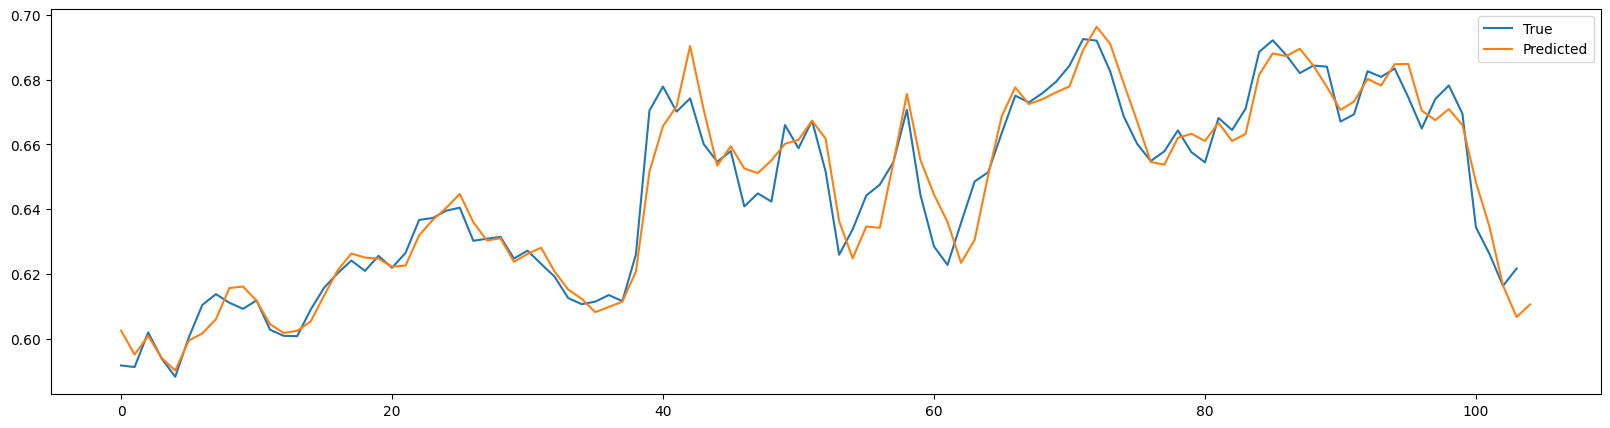

In [6]:
# plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(gt_test, label="True")
plt.plot(final_y_test, label="Predicted")
plt.legend()
plt.show()

(29.876629, 0.7013994184576391, 0.3427733)
(16.832823, -8.1155834506045, 0.09629772)


In [7]:
STOCK_NAME = "^IXIC"
yahoo_financials = YahooFinancials(STOCK_NAME)
data = yahoo_financials.get_historical_price_data("2000-01-01", "2023-11-23", "daily")
df = pd.DataFrame(data[STOCK_NAME]["prices"])
stockarray = df["adjclose"].values
datearray = df["formatted_date"].values
len(stockarray)

6012

In [8]:
stockarray = stockarray/1000

2/2 [==============================] - 0s 796us/step
Train RMSE: 0.07215393626718877
Train R2: 0.9996274938602349
Test RMSE: 0.11955371241215011
Test R2: 0.9164441079947887


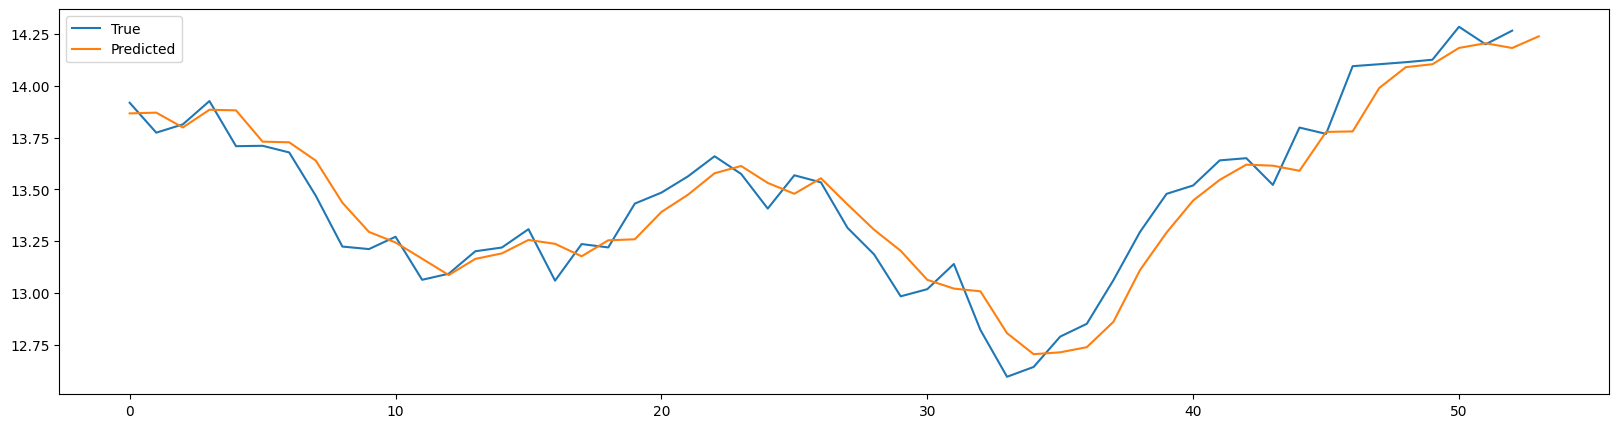

In [9]:
final_y_test, final_y_train, gt_test, gt_train = pecnet(stockarray, 53)
# calculate construct prediction and real arrays
out_of_test_pred = final_y_test[-1]
test_preds = final_y_test[:-1] # discard last day since it is the out of test prediction
train_preds = final_y_train
train_reals = stockarray[8:-len(test_preds)] # discard first 8 days since the model needs 8 days to predict
test_reals = stockarray[-len(test_preds):]
# calculate scores
train_rmse = np.sqrt(mean_squared_error(train_reals, train_preds))
train_r2 = r2_score(train_reals, train_preds)
test_rmse = np.sqrt(mean_squared_error(test_reals, test_preds))
test_r2 = r2_score(test_reals, test_preds)

print(f'Train RMSE: {train_rmse}')
print(f'Train R2: {train_r2}')
print(f'Test RMSE: {test_rmse}')
print(f'Test R2: {test_r2}')

# plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot(test_reals, label="True")
plt.plot(final_y_test, label="Predicted")
plt.legend()
plt.show()